In [3]:
import pandas as pd
energy = pd.read_csv("../Data/energy.csv")
idcols = [
    'Country',
    'Year',
    'Region'
]

rencols = [
    'electbyfuel_hydro', 
    'hydro_ej',
    'biofuels_prod_pj', 
    'biofuels_cons_pj',
]

energy.columns
df = energy[idcols + rencols]
df.head()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

### using a modified Data Preprocessor class based off /Harsh/main.py

class Data:
    rencols = [
        'electbyfuel_hydro', 
        'hydro_ej',
        'biofuels_prod_pj', 
        'biofuels_cons_pj',
    ]
    
    def __init__(self, df, year):
        self.df = df.copy()
        self.imputer = SimpleImputer(strategy="mean")
        self.encoder = OrdinalEncoder()
        self.year = year
        self.X = df.copy()
        self.X = self.get_year(year)
        self.w_o_outliers = self.remove_all_outliers()
        
    def plot_outliers(self):
        pltdata = [
            len(self.w_o_outliers),
            len(self.X) - len(self.w_o_outliers)
        ]
        plt.pie(pltdata, labels = [f"Not Outliers - {pltdata[0]}", f"Outliers - {pltdata[1]}"])
        plt.show()

        
    def plot_outliers_for_col(self):
        figure, axis = plt.subplots(2, 2, figsize = (10, 6))
        pos = 0
        for col in rencols:
            axis[pos//2, pos%2].set_title(f"Outliers for {col}", fontsize = 15)
            axis[pos//2, pos%2].boxplot(self.X[col])
            pos += 1
        figure.tight_layout(pad = 1.0)
        plt.show()

    def get_year(self, year):
        grouped_data = self.X.groupby(['Year'])
        grouped_data.get_group(year)
        return grouped_data.get_group(year)
    
    def show_outliers(self, column):
        try:
            sns.boxplot(x=self.X[column])
            plt.show()
        except:
            print("There was some error while accessing the given column")

    def IQR(self):
        temp1 = self.X[rencols].copy()
        temp2 = self.X[rencols].copy()
        Q1 = (temp1).quantile(0.25)
        Q3 = (temp2).quantile(0.75)
        iqr = Q3-Q1
        return (Q1, Q3, iqr)
    
    def remove_all_outliers(self):
        Q1, Q3, IQR = self.IQR()
        prev = len(self.X.index)
        self.X["torem"] = True
        for col in rencols:
            mask = ~((self.X[col] < (Q1[col] - 1.5 * IQR[col])) | (self.X[col] > (Q3[col] + 1.5 * IQR[col])))
            self.X['torem'] &= mask
        outliers_count = (self.X['torem'] == False).sum()
        print(f"{outliers_count} outliers were detected")
        return self.X[self.X["torem"]]
    
    def remove_outliers(self, col):
        sorts = self.X[col].sort_values()
        Q1 = sorts.quantile(0.25)
        Q3 = sorts.quantile(0.75)
        IQR = Q3-Q1
        prev = len(self.X.index)
        return sorts[~((sorts < (Q1 - 1.5 * IQR)) |
                         (sorts > (Q3 + 1.5 * IQR)))]
data = Data(df, year=2021)

def scale(data):
    return data/max(data)

20 outliers were detected


In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_clusters(x, y, num_clusters, xlabel, ylabel, title, ptlabel = None):
    data = list(zip(x, y))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)
    labels = kmeans.labels_
    plt.scatter(x, y, c=labels, cmap='viridis', edgecolor='k', s=30)
    plt.title(title)
    if ptlabel is not None :
        ind = 0
        for (i, j) in data:
            plt.text(i, j, ptlabel[ind], fontsize = 6)
            ind += 1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


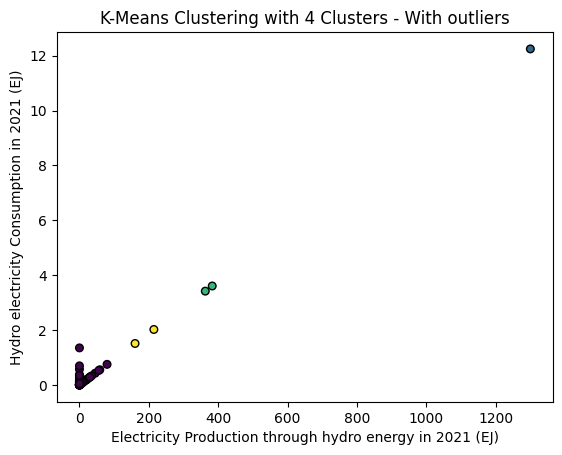

In [13]:
num_clusters = 4
plot_clusters(data.X['electbyfuel_hydro'], data.X['hydro_ej'], num_clusters,
              'Electricity Production through hydro energy in 2021 (EJ)', 'Hydro electricity Consumption in 2021 (EJ)', 
              f'K-Means Clustering with {num_clusters} Clusters - With outliers'
            #   ,list(data.X["Country"])
)

20 outliers were detected
20 outliers were detected


c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


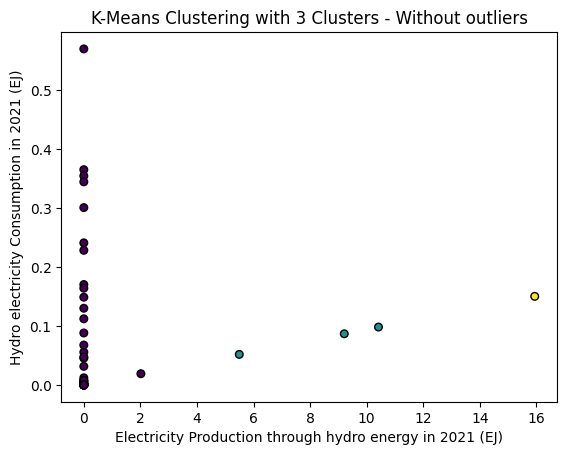

In [14]:
num_clusters = 3
plot_clusters(data.remove_all_outliers()['electbyfuel_hydro'], data.remove_all_outliers()['hydro_ej'], num_clusters,
              'Electricity Production through hydro energy in 2021 (EJ)', 
              'Hydro electricity Consumption in 2021 (EJ)', 
              f'K-Means Clustering with {num_clusters} Clusters - Without outliers'
            #   ,list(data.X["Country"])
)

c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


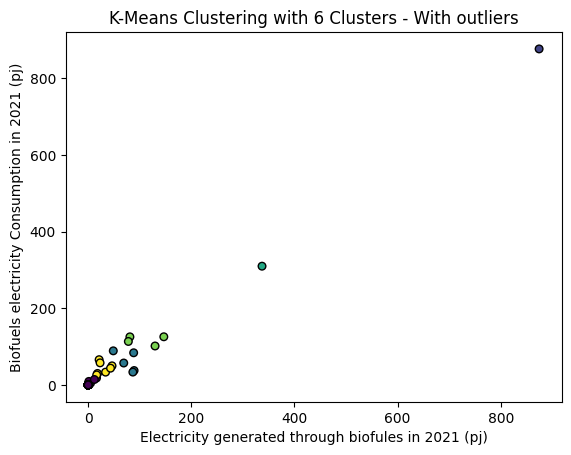

In [15]:
num_clusters = 6
plot_clusters(data.X['biofuels_prod_pj'], data.X['biofuels_cons_pj'], num_clusters, 
              'Electricity generated through biofules in 2021 (pj)', 'Biofuels electricity Consumption in 2021 (pj)', 
              f'K-Means Clustering with {num_clusters} Clusters - With outliers',
            #   list(data.X["Country"])
)

20 outliers were detected
20 outliers were detected
20 outliers were detected


c:\Users\rlsha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


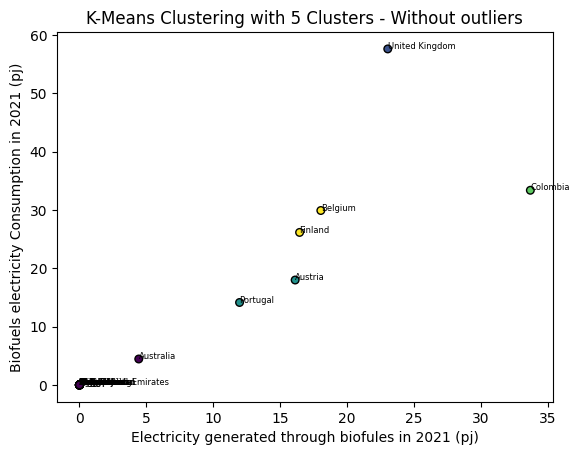

In [16]:
num_clusters = 5
plot_clusters(data.remove_all_outliers()['biofuels_prod_pj'], data.remove_all_outliers()['biofuels_cons_pj'], 
              num_clusters, 
              'Electricity generated through biofules in 2021 (pj)', 'Biofuels electricity Consumption in 2021 (pj)', 
              f'K-Means Clustering with {num_clusters} Clusters - Without outliers',
              list(data.remove_all_outliers()["Country"])
)